In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Creating a simple expression for understanding back propagation concepts
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

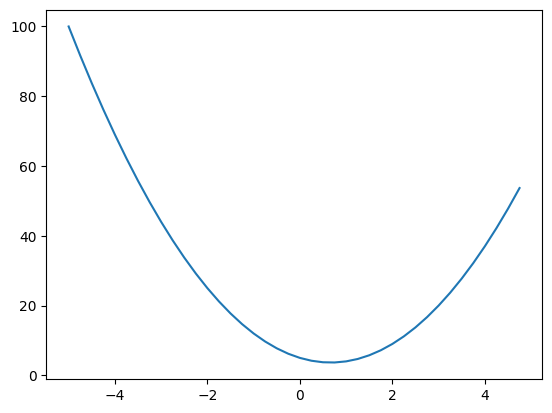

In [5]:
plt.plot(xs, ys)

In [6]:
h = 0.00000001
x = 2/3
## Eqn of slope 
## Refer :- https://calcworkshop.com/wp-content/uploads/definition-derivative-formula.png
(f(x + h) - f(x))/h

0.0

In [7]:
## Creating another expression
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
## Add a small value to the each variable and review the slope
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

## a += h
## b += h
c += h

d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [16]:
## 
class Value:

    def __init__(self, data, _children= (), _op= '', label= ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda : None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():                     ## Here we define the grad calculated below as a function. in the case of + it will be the ouput's grad.
            self.grad += 1.0 * out.grad       ## Created a _backward function and each time we assign a onject of that function with each specific nodes
            other.grad += 1.0 * out.grad      ## Then we cann with the variables the function executes and assign the grad values.
        out._backward = _backward
        
        return out
        
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad    ## In the of multiplication it will be like this.
            other.grad += self.data * out.grad    ## Detailed explanation below, how we got this 
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
        
    def backward(self):         ## Change the backward function 
        topo = []
        visited = set()
        def build_topo(v):
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):  
            node._backward()
        


a = Value(2.0, label= 'a')
b = Value(-3.0, label= 'b')
c = Value(10.0, label= 'c')
e = a*b ; e.label= 'e'
d = e + c ; d.label= 'd'
f = Value(-2.0 , label= 'f')
L = d * f ; L.label= 'L'
L

Value(data=-8.0)

In [10]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [11]:
d._op

'+'

In [8]:
## Functions for display the expressions and nodes and edges (Tree structure)
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_root(root):
    dot = Digraph(format= 'svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name= uid, label= "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape= 'record')
        if n._op:
            dot.node(name = uid + n._op, label= n._op)
            dot.edge(uid + n._op, uid) 
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

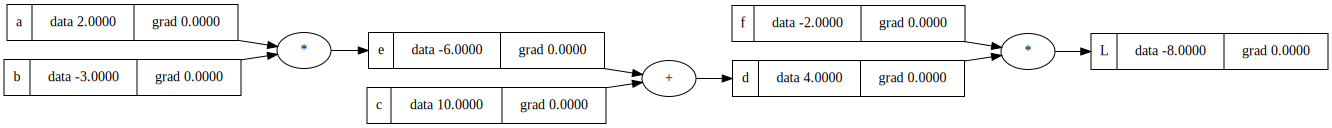

In [13]:
draw_root(L)

In [14]:
## Assign the calculated gradients to the variables
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

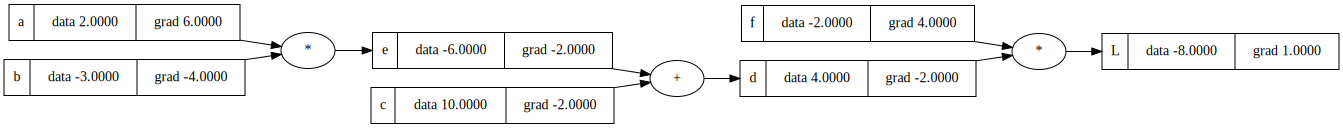

In [15]:
draw_root(L)

In [16]:
## Creating same local variables as in class to check the gradient 
## Calculate gradient of each variable is verifying it with the class variables
## We need to find the derivative of every node with respect to the L 

## dL/dL = 1.0
## dL/dd ::> L = d * f  ::> d( d * f)/ dd ==> f ==> -2.0
## dL/df ::> d( d * f)/ df ==> d ==> 4.0
## dL/de ::> dL/dd * dd/de ::> -2 * d( e + c)/ de ::> -2 * 1 ==> -2.0
## dL/dc ::> dL/dd * dd/dc ::> -2 * d( e + c)/ dc ::> -2 * 1 ==> -2.0
## dL/db ::> dL/de * de/db ::> -2 * d( a * b)/ db ::> -2 * a ==> -2 * 2 ==> -4.0
## dL/da ::> dL/de * de/da ::> -2 * d( a * b)/ da ::> -2 * b ==> -2 * -3 ==> 6.0

## We can verify the above using the below methods thus it same or not 
## Thus we change the grad of each variable according to this in above ^

def lol():

    h = 0.001
    a = Value(2.0, label= 'a')
    b = Value(-3.0, label= 'b')
    c = Value(10.0, label= 'c')
    e = a*b ; e.label= 'e'
    d = e + c ; d.label= 'd'
    f = Value(-2.0 , label= 'f')
    L = d * f ; L.label= 'L'
    L1 = L.data

    a = Value(2.0, label= 'a')
    b = Value(-3.0 , label= 'b')
    c = Value(10.0, label= 'c')
    e = a*b ; e.label= 'e'
    d = e + c ; d.label= 'd'
    f = Value(-2.0 + h, label= 'f')
    L = d * f ; L.label= 'L'
    L2 = L.data

    print((L2 - L1)/ h)

lol()

3.9999999999995595


In [17]:
## Going to change the value of L , first change decrease the value of L
## Nudged all the value of input in the direction of gradient 
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

## Forward value 

e = a * b
d = e + c
L = d * f 

print(L.data)

## This is only one step of optimization and value of L decreased thus we do multiple times the value of L decreases to zero.


-7.286496


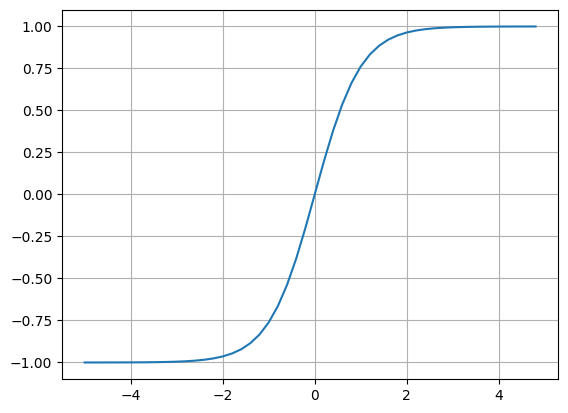

In [18]:
## Backpropagation through a neuron(Perceptron)
## A single-layer perceptron is the basic unit of a neural network. A perceptron consists of input values, 
## weights and a bias, a weighted sum and activation function.
## Refer :- https://lucidar.me/fr/neural-networks/files/perceptron.png

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

## Tanh function scale the values b/w -1 and 1

In [49]:
## Input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
## Weights w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
## Bias b
b = Value(6.8813735870195432, label='b') ## 8, 6.7
x1w1 = x1*w1 ; x1w1.label= 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label= 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label= 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'

In [20]:
o.grad = 1.0

## o = tanh(n)
## derivative of tanh is 1 - tanh(n)**2
## do/dn = d(tanch(n))/dn ::> 1 - o **2 ::> 1 - (0.7071)**2
n.grad = 1 - o.data **2

## In the case of x1w1x2w2 the + operator distribute the previous gradient, refer the previous example, Thus,
x1w1x2w2.grad = n.grad
b.grad = n.grad

## In the case of x1w1 and x2w2 same things occur the gradient of x1w1x2w2 is distributed to both of them,
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

## In the case of x1, w1, x2, w2 it becomes 
x1.grad = x1w1.grad * w1.data      ## Multiply the other term with the grad of the connected node
w1.grad = x1w1.grad * x1.data      ## Check the previous example to understand.
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

## We write these all as a function in the class named _backward.

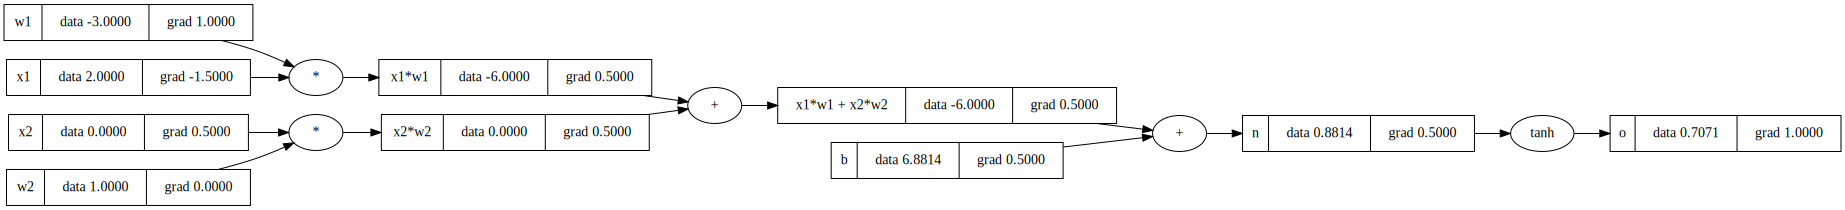

In [21]:
draw_root(o)

In [32]:
## Cleared all grad and calculate the grad using the created function in the class.(_backward)
o.grad = 1.0

In [33]:
o._backward()           ## call the fucntions associated with each onjects we created.
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

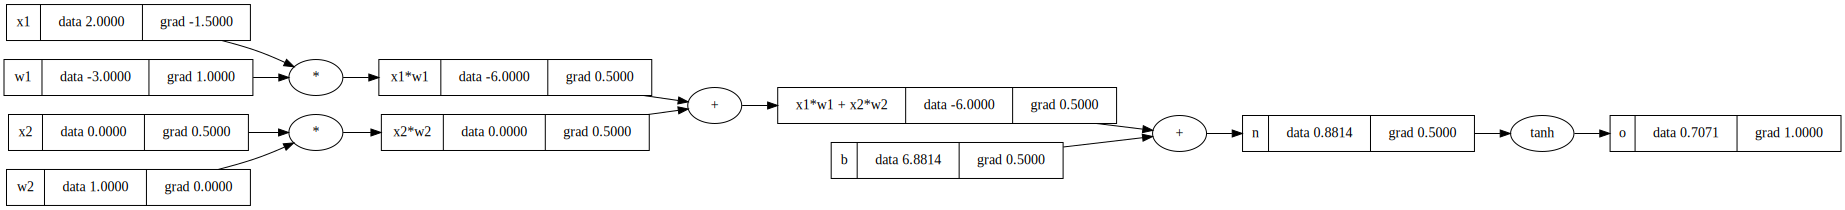

In [34]:
draw_root(o)

In [39]:
## Instead of calling backward maunally, we can achieve these using a function, but before we need to sort the nodes in the order of calling 
## the backward, thus we use the topological sort.
## Topological sort is basically a laying out of a graph such that all the edges are go only from left to right.
topo = []
visited = set()
def build_topo(v):
    visited.add(v)
    for child in v._prev:
        build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [40]:
o.grad = 1.0
for node in reversed(topo):  ## The values in the topo is in reverse order
    node._backward()         ## We need to hide these under the class

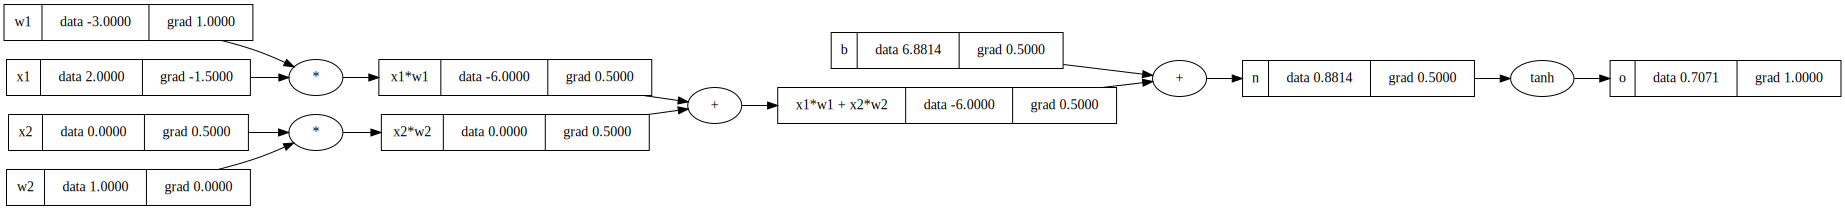

In [41]:
draw_root(o)

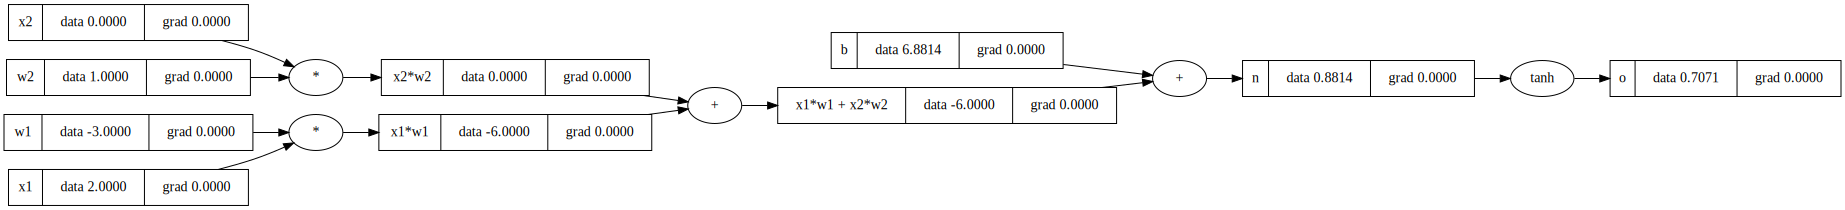

In [43]:
draw_root(o)

In [50]:
o.backward()

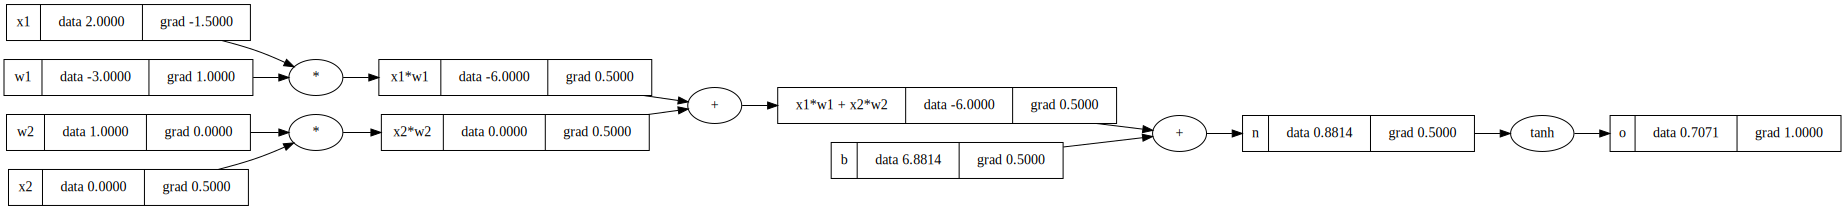

In [51]:
draw_root(o)

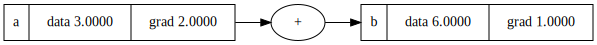

In [11]:
a = Value(3.0, label= 'a') 
b = a + a ; b.label= 'b'
b.backward()
draw_root(b)

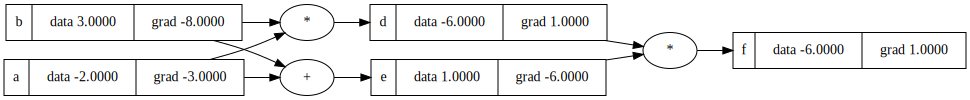

In [17]:
a = Value(-2.0, label= 'a')
b = Value(3.0, label= 'b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()

draw_root(f)

In [8]:
 ## Now take the value class once agian 
class Value:

    def __init__(self, data, _children= (), _op= '', label= ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda : None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) ## Check if other is an instance of class if not wrap as an object
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():                     ## Here we define the grad calculated below as a function. in the case of + it will be the ouput's grad.
            self.grad += 1.0 * out.grad       ## Created a _backward function and each time we assign a onject of that function with each specific nodes
            other.grad += 1.0 * out.grad      ## Then we cann with the variables the function executes and assign the grad values.
        out._backward = _backward
        
        return out
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad    ## In the of multiplication it will be like this.
            other.grad += self.data * out.grad    ## Detailed explanation below, how we got this 
        out._backward = _backward
        
        return out

    def __rmul__(self, other): #other * self
        return self * other ## Actually  we swap the variables thus its occurs like a.__mul__(1)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):   ## Exponension
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
            out._backward = _backward
        
    def backward(self):         ## Change the backward function 
        topo = []
        visited = set()
        def build_topo(v):
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):  
            node._backward()

In [2]:
a = Value(2.0)   ## In this case the defined other in the class is a value object 
a + 1            ## Thus we cannot do this,thus need to do some changes in __add__ function
## Need to do this with all the operations.

AttributeError: 'int' object has no attribute 'data'

In [4]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [5]:
a = Value(2.0) ## In the case of multiplication if we call a * 2, there occuring like a.__mul__(2), but if we call 2 * a, 2.__mul__(a)
2 * a          ## which is not possible, can be implement using define a new function named rmul

TypeError: unsupported operand type(s) for *: 'int' and 'Value'

In [13]:
a = Value(2.0) 
2 * a 
print(a.exp())

None


In [14]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
x3 = Value(3.0, label = 'x3')

## Weights w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
w3 = Value
## Bias b
b = Value(6.8813735870195432, label='b') ## 8, 6.7
x1w1 = x1*w1 ; x1w1.label= 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label= 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label= 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'